In [1]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import heapq
import math
import os
from collections import deque

In [2]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

In [3]:
action_dict = {'a': torch.tensor([0., -1.]), 'd': torch.tensor([0., 1.]), 'w': torch.tensor([-1., 0.]), 's': torch.tensor([1., 0.])}

def do(snake: torch.Tensor, action):
    reward = 0
    positions = snake.flatten().topk(2)[1]
    [pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
    #print('direction', (pos_cur - pos_prev)) # Направление движения
    pos_next = (pos_cur + action) % torch.Tensor([snake.shape]).squeeze(0) 
    
    pos_cur = pos_cur.int()
    pos_next = pos_next.int()
    
    # Проверка на столкновение
    if (snake[tuple(pos_next)] > 0).any():
        reward = -100
        return reward,(snake[tuple(pos_cur)] - 2).item()  # Возвращаем счёт (длина змейки минус 2)
    
    # Кушаем яблоко
    if snake[tuple(pos_next)] == -1:
        pos_food = (snake == 0).flatten().to(torch.float).multinomial(1)[0] # Генерируем позицию яблока
        snake[unravel(pos_food, snake.shape)] = -1 # Добавляем яблоко в игру
        reward= 10
        
    else: # Двигаемся в пустую клетку
        snake[snake > 0] -= 1  # Устанавливаем все значения в теле змеи равными 1

    snake[tuple(pos_next)] = snake[tuple(pos_cur)] + 1 # перемещаем голову
    return reward, (snake[tuple(pos_cur)] - 2).item()


In [68]:
class Neuro_BigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1=nn.Conv2d(3, 32, kernel_size=(3,3), padding = 1)
        # self.conv1=nn.Conv2d(32, 64, kernel_size=(3,3), padding = 1)
        # self.fl = nn.Flatten()
        self.fc1=nn.Linear(32*32, 256)
        self.fc2=nn.Linear(256,3)

    def forward(self,x):
        # x = F.relu(self.conv1(x))
        # x= F.relu(self.conv2(x))
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [89]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = torch.optim.SGD(model.parameters(), lr=self.lr, momentum=0.4, weight_decay=0.0001)
        self.criterion = nn.CrossEntropyLoss()#.cuda()

    def train_step(self, state, action, reward, next_state, done):
        # print(state)
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)
        if len(state.shape) == 2:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

In [90]:
class Champion():
    def __init__(self):
        super().__init__()
        self.n_games = 0
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Neuro_BigBoss()#.cuda()
        self.eps = 0
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
            # print(1)
        else:
            # print(2)
            mini_sample = self.memory

        # states, actions, rewards, next_states, dones = zip(*mini_sample)
        # states = list(states)
        # # actions = list(actions)
        # # rewards = list(rewards)
        # next_states = list(next_states)
        # dones = list(dones)
        # print(states)
        # self.trainer.train_step(states, actions, rewards, next_states, dones)
        for state, action, reward, next_state, done in mini_sample:
           self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            prediction = self.model(state)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move
    
    


In [91]:
class Node:
    def __init__(self, x, y):
        self.x = x  # Координата x узла на карте
        self.y = y  # Координата y узла на карте
        self.g = 0  # Расстояние от начального узла до текущего узла
        self.h = 0  # Примерное расстояние от текущего узла до конечного узла
        self.f = 0  # Сумма g и h
        self.parent = None  # Родительский узел, используется для восстановления пути

    # Переопределяем оператор сравнения для сравнения узлов
    def __lt__(self, other):
        return self.f < other.f

    # Переопределяем оператор равенства для сравнения узлов
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))

# Определяем функцию для нахождения пути с помощью алгоритма A*
def astar(start, end, obstacles):

    # Создаем начальный и конечный узлы
    start_node = Node(start[0], start[1])
    end_node = Node(end[0], end[1])

    # Инициализируем очередь с приоритетами
    open_list = []
    heapq.heappush(open_list, start_node)

    # Инициализируем множество посещенных узлов
    closed_set = set()

    # Пока очередь с приоритетами не пуста
    while open_list:
        # Извлекаем узел с наименьшей оценкой f
        current_node = heapq.heappop(open_list)
        # Если текущий узел является конечным
        if current_node == end_node:
            # Восстанавливаем путь от конечного узла до начального
            path = []
            while current_node.parent is not None:
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[-1]

        # Добавляем текущий узел в множество посещенных узлов
        closed_set.add(current_node)

        # Получаем соседние узлы
        neighbors = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                # Вычисляем координаты соседнего узла
                x = current_node.x + dx
                y = current_node.y + dy
                # Игнорируем узлы за пределами карты
                if x < 0 :
                    x=len(obstacles)-1
                if x>=len(obstacles):
                    x=0
                if y<0:
                    y=len(obstacles)-1
                if y>=len(obstacles):
                    y=0
                # Игнорируем препятствия
                if obstacles[x][y] == 1:
                    continue
                # Создаем новый узел и добавляем его в список соседей
                neighbor = Node(x, y)
                neighbors.append(neighbor)

        # Для каждого соседнего узла
        for neighbor in neighbors:
            # Если соседний узел уже был посещен, пропускаем его
            if neighbor in closed_set:
                continue

            # Вычисляем расстояние от начального узла до соседнего узла
            new_g = current_node.g + 1

            # Если соседний узел уже находится в очереди с приоритетами
            if nfo := next((n for n in open_list if n == neighbor), None):
                # Если новое расстояние до соседнего узла меньше, чем старое, обновляем значения g, h и f
                if new_g < nfo.g:
                    nfo.g = new_g
                    nfo.h = math.sqrt((end_node.x - nfo.x) ** 2 + (end_node.y - nfo.y) ** 2)
                    nfo.f = nfo.g + nfo.h
                    nfo.parent = current_node
                    # Обновляем приоритет соседнего узла в очереди с приоритетами
                    heapq.heapify(open_list)
            else:
                # Иначе добавляем соседний узел в очередь с приоритетами и вычисляем значения g, h и f
                neighbor.g = new_g
                neighbor.h = math.sqrt((end_node.x - neighbor.x) ** 2 + (end_node.y - neighbor.y) ** 2)
                neighbor.f = neighbor.g + neighbor.h
                neighbor.parent = current_node
                heapq.heappush(open_list, neighbor)

    # Если конечный узел недостижим, возвращаем None
    return None


In [92]:
class Snake:
    def __init__(self):
        self.field = torch.zeros((32, 32), dtype=torch.float)
        self.field[0, :3] = torch.Tensor([1, 2, -1]) # [хвост, голова, яблоко]
        self.a = torch.zeros((32, 32), dtype=torch.float)
        self.dirrection = torch.tensor([0,1])
        self.head_cords = [0,1]
        self.apple_cords = [0,2]
        self.neighbours = [[31,1],[0,0],[0,2],[1,1]]
        self.collision = [False, True, False, False]
        self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
    
    def set_dirrection(self, dir):
        dir = torch.tensor(dir)
        if not torch.allclose(dir, self.dirrection):
            self.dirrection = dir
            if torch.allclose(dir, torch.tensor([0, 1])):
                self.availible_passes = [torch.tensor([-1, 0]), torch.tensor(self.dirrection), torch.tensor([1, 0])]
            if torch.allclose(dir, torch.tensor([1, 0])):
                self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
            if torch.allclose(dir, torch.tensor([0, -1])):
                self.availible_passes = [torch.tensor([1, 0]), torch.tensor(self.dirrection), torch.tensor([-1, 0])]
            if torch.allclose(dir, torch.tensor([-1, 0])):
                self.availible_passes = [torch.tensor([0, -1]), torch.tensor(self.dirrection), torch.tensor([0, 1])]
    
    def set_head_cords(self,head):
        self.head_cords = head
    
    def set_apple_cords(self,apple):
        self.apple_cords = apple
    
    def set_neighbours(self):
        counter = 0
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                x = self.head_cords[0] + dx
                y = self.head_cords[1] + dy

                if x < 0 :
                    x=31
                if x>=32:
                    x=0
                if y<0:
                    y=31
                if y>=32:
                    y=0

                self.neighbours[counter] = [x,y]
                if self.field[x][y] > 0:
                    self.collision[counter] = True
                else:
                    self.collision[counter] = False
                counter+=1

    def get_state(self):
        return [self.dirrection,self.head_cords, self.apple_cords,self.neighbours,self.collision]
    
    def make_step(self, step):
        step=self.availible_passes[np.argmax(step)]
        reward = 0
        a = torch.zeros(self.field.shape)
        a[self.field>0]=1
        a[self.field==self.field.max()]=2
        a[self.field<0]=-1
        head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
        apple = [(self.field.argmin()/32).int().item(),
            (self.field.argmin()%32).item()]
        head[1]=head[1][0]
        head_cords = [head[0].item(),head[1]]
        self.set_apple_cords(apple)
        self.set_head_cords(head_cords)
        self.set_neighbours()
        self.set_dirrection(step)
        reward, score = do(self.field, step)
        done = False
        if reward == -100:
            done = True
        return reward, done, score
        

In [93]:

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
agent = Champion()
game = Snake()
while True:
    # get old state
    state_old = game.field

    # get move
    final_move = agent.get_action(state_old)

    # perform move and get new state
    reward, done, score = game.make_step(final_move)

    state_new = game.field

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new, done)

    # remember
    agent.remember(state_old, final_move, reward, state_new, done)

    if done:
        # train long memory, plot result
        game=Snake()
        agent.n_games += 1
        agent.train_long_memory()

        if score > record:
            record = score
            agent.model.save()

        print('Game', agent.n_games, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.n_games
        plot_mean_scores.append(mean_score)

C:\Users\User\AppData\Local\Temp\ipykernel_11488\254939064.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_11488\254939064.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = torch.tensor(dir)
C:\Users\User\AppData\Local\Temp\ipykernel_11488\254939064.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, -1]), torch.tensor(self.dirrection), torch.te

Game 1 Score 2.0 Record: 2.0
Game 2 Score 2.0 Record: 2.0
Game 3 Score 2.0 Record: 2.0
Game 4 Score 2.0 Record: 2.0
Game 5 Score 3.0 Record: 3.0
Game 6 Score 2.0 Record: 3.0
Game 7 Score 2.0 Record: 3.0
Game 8 Score 2.0 Record: 3.0
Game 9 Score 2.0 Record: 3.0
Game 10 Score 2.0 Record: 3.0
Game 11 Score 2.0 Record: 3.0
Game 12 Score 2.0 Record: 3.0
Game 13 Score 2.0 Record: 3.0
Game 14 Score 2.0 Record: 3.0
Game 15 Score 2.0 Record: 3.0
Game 16 Score 2.0 Record: 3.0


In [85]:

snake = Snake()
reward = 0
while True:
    a = torch.zeros(snake.field.shape)
    a[snake.field>0]=1
    a[snake.field==snake.field.max()]=2
    a[snake.field<0]=-1
    head = [snake.field.topk(1)[0].argmax().numpy(),snake.field.topk(1)[1][snake.field.topk(1)[0].argmax()].numpy()]
    apple = [(snake.field.argmin()/32).int().item(),
        (snake.field.argmin()%32).item()]
    head[1]=head[1][0]
    head_cords = [head[0].item(),head[1]]
    snake.set_apple_cords(apple)
    snake.set_head_cords(head_cords)
    snake.set_neighbours()
    if reward == -100:
        break
    path = astar( head_cords, apple, a)
    if path == None:
        break
    cords = np.array(path)
    # print(cords, np.array(head_cords))
    cords-=np.array(head_cords)
    if cords[0]==-31:
        cords[0]=1
    if cords[0]==31:
        cords[0]=-1
    if cords[1]==-31:
        cords[1]=1
    if cords[1]==31:
        cords[1]=-1
    # fig, ax = plt.subplots(1, 1)
    # img = ax.imshow(a)
    action = {'val': 1}
    n = 0
    score = None
    # img.set_data(a)
    cords_list=cords.tolist()
    snake.set_dirrection(cords_list)
    reward, score = do(snake.field, cords)
    n += 1
    

[[0, 1], [13, 9], [23, 1], [[12, 9], [13, 8], [13, 10], [14, 9]], [False, True, False, False]]


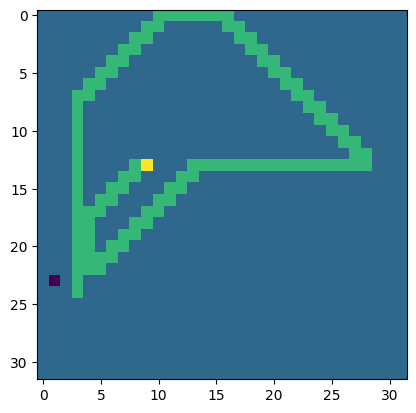

In [87]:
fig, ax = plt.subplots(1, 1)
a = torch.zeros(snake.field.shape)
positions = snake.field.flatten().topk(2)[1]
[pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.field.shape)) for x in positions]
a[snake.field>0]=1
a[snake.field==snake.field.max()]=2
a[snake.field<0]=-1
# print(a)
img = ax.imshow(a)
action = {'val': 1}
# print(a)
n = 0
score = None

while n<1:
    img.set_data(a)
    # reward, score = do(snake.field, action_dict['a'])
    n += 1
# print(reward, score)
# print(score)
state = snake.get_state()
print(state)

In [60]:
final_move = [0,0,0]
if random.randint(0, 200) < 80:
    move = random.randint(0, 2)
    final_move[move] = 1
np.argmax(final_move)

1